# Proyek Analisis Data: [E-Commerce Public Dataset]
- **Nama:** [Muhammad Fadhil Diandra]
- **Email:** [fadhildiandra21@gmail.com]
- **ID Dicoding:** [MC589D5Y2494]

## Menentukan Pertanyaan Bisnis

- Bagaimana pola keterlambatan pengiriman pesanan berdasarkan kategori produk dan lokasi pelanggan dalam dua tahun terakhir?

- Bagaimana hubungan antara metode pembayaran yang digunakan pelanggan dengan nilai total transaksi dan tingkat pengembalian produk?

## Import Semua Packages/Library yang Digunakan

In [3]:
#Melakukan import semua library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import datetime as dt

**Insight:**
- Berikut adalah semua library yang digunakan untuk melakukan visualisasi data

## Data Wrangling

### Gathering Data

In [4]:
#Melakukan download dataset dari link yang tersedia di kaggle
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("Path to dataset files:", path)


100%|██████████| 42.6M/42.6M [00:00<00:00, 128MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2


**Insight:**
- Selanjutnya kita melakukan pengumpulan data yang ingin kita kumpulkan dengan menuliskan path data yang kita ingin analisis

In [5]:
# Mendefinisikan path dari dataset
dataset_path = os.path.join(path, "")

# Memanggil dan memberi nama setiap csv yang dibutuhkan
orders = pd.read_csv(os.path.join(dataset_path, "olist_orders_dataset.csv"))
order_items = pd.read_csv(os.path.join(dataset_path, "olist_order_items_dataset.csv"))
products = pd.read_csv(os.path.join(dataset_path, "olist_products_dataset.csv"))
payments = pd.read_csv(os.path.join(dataset_path, "olist_order_payments_dataset.csv"))
customers = pd.read_csv(os.path.join(dataset_path, "olist_customers_dataset.csv"))
returns = pd.read_csv(os.path.join(dataset_path, "olist_order_reviews_dataset.csv"))

Insight:

-  Dataset terdiri dari beberapa tabel yang saling berhubungan dan dapat digabungkan menggunakan order_id dan customer_id.
- Dataset Orders berisi informasi tentang waktu pemesanan, ID pelanggan, dan status pengiriman.
- Dataset Order Items menyediakan detail tentang produk yang dibeli, harga, dan jumlahnya.
- Dataset Products mengkategorikan produk ke dalam berbagai segmen.
- Dataset Payments menunjukkan metode pembayaran yang digunakan dan jumlah transaksi.
- Dataset Customers menghubungkan pesanan dengan lokasi pelanggan.
- Dataset Returns mencakup skor ulasan, yang dapat membantu menyimpulkan pengembalian produk.

### Assessing Data

In [6]:
# Melihat tipe data dan menemukan missing values yang ada
print(orders.info())
print(order_items.info())
print(products.info())
print(payments.info())
print(customers.info())
print(returns.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  ob

**Insight:**
- Satu pesanan dapat memiliki beberapa metode pembayaran.
- Kategori produk menggunakan bahasa Portugis dan mungkin perlu diterjemahkan.
- Skor ulasan dapat digunakan untuk memperkirakan pengembalian produk (skor rendah mungkin menunjukkan pengembalian).

### Cleaning Data

In [7]:
# Mengecek struktur data
print("Kolom dalam products:", products.columns)

# Disini saya memastikan prouduct category name agar dapat diketahui
if 'product_category_name' not in products.columns:
    if 'product_category_name_english' in products.columns:
        products.rename(columns={'product_category_name_english': 'product_category_name'}, inplace=True)

#  Menggabungkan data untuk analisis
orders = orders.merge(order_items, on='order_id', how='left', suffixes=('', '_orderitem'))
orders = orders.merge(products, on='product_id', how='left', suffixes=('', '_product'))
orders = orders.merge(customers, on='customer_id', how='left', suffixes=('', '_customer'))
orders = orders.merge(payments, on='order_id', how='left', suffixes=('', '_payment'))
orders = orders.merge(returns[['order_id', 'review_score']], on='order_id', how='left')

# Mengecek kolom setelah dilakukan penggabungan
print("Kolom dalam orders setelah merge:", orders.columns)

# Disini saya mengkonversi waktu
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

# Melakukan filter data selama 2 tahun terakhir
latest_date = orders['order_purchase_timestamp'].max()
two_years_ago = latest_date - pd.DateOffset(years=2)
orders_filtered = orders[orders['order_purchase_timestamp'] >= two_years_ago]

# Menghitung waktu keterlambatan
orders_filtered['delivery_delay'] = (orders_filtered['order_delivered_customer_date'] - orders_filtered['order_purchase_timestamp']).dt.days
orders_filtered = orders_filtered.dropna(subset=['delivery_delay'])



Kolom dalam products: Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')
Kolom dalam orders setelah merge: Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value'

<ipython-input-7-e7a354c1120c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_filtered['delivery_delay'] = (orders_filtered['order_delivered_customer_date'] - orders_filtered['order_purchase_timestamp']).dt.days


**Insight:**
- Nilai yang hilang pada tanggal pengiriman telah ditangani dengan memfilter data yang relevan.
- Menggabungkan dataset memungkinkan tampilan yang lebih terintegrasi untuk analisis.
- Format timestamp telah dikonversi ke datetime agar lebih mudah diproses.

## Exploratory Data Analysis (EDA)

### Explore ...

In [8]:
# Ringkasan statistic yang didapatkan
print(orders_filtered.describe())

            order_purchase_timestamp  order_delivered_customer_date  \
count                         115379                         115379   
mean   2018-01-01 17:20:52.600906496  2018-01-14 04:29:29.534551296   
min              2016-12-23 23:16:47            2016-12-28 15:54:44   
25%       2017-09-13 19:30:25.500000            2017-09-25 20:02:59   
50%              2018-01-19 14:30:28            2018-02-01 20:49:54   
75%       2018-05-04 15:03:26.500000     2018-05-15 15:22:23.500000   
max              2018-08-29 15:00:37            2018-10-17 13:22:46   
std                              NaN                            NaN   

       order_item_id          price  freight_value  product_name_lenght  \
count  115379.000000  115379.000000  115379.000000        113743.000000   
mean        1.196856     119.894531      19.983495            48.801588   
min         1.000000       0.850000       0.000000             5.000000   
25%         1.000000      39.900000      13.080000          

**Insight:**
- Keterlambatan pengiriman bervariasi secara signifikan di berbagai kategori.
- Jenis pembayaran memiliki perbedaan besar dalam nilai transaksi.
- Beberapa produk cenderung lebih sering dikembalikan berdasarkan skor ulasan.

## Visualization & Explanatory Analysis

### Pertanyaan 1: Bagaimana pola keterlambatan pengiriman pesanan berdasarkan kategori produk dan lokasi pelanggan dalam dua tahun terakhir?


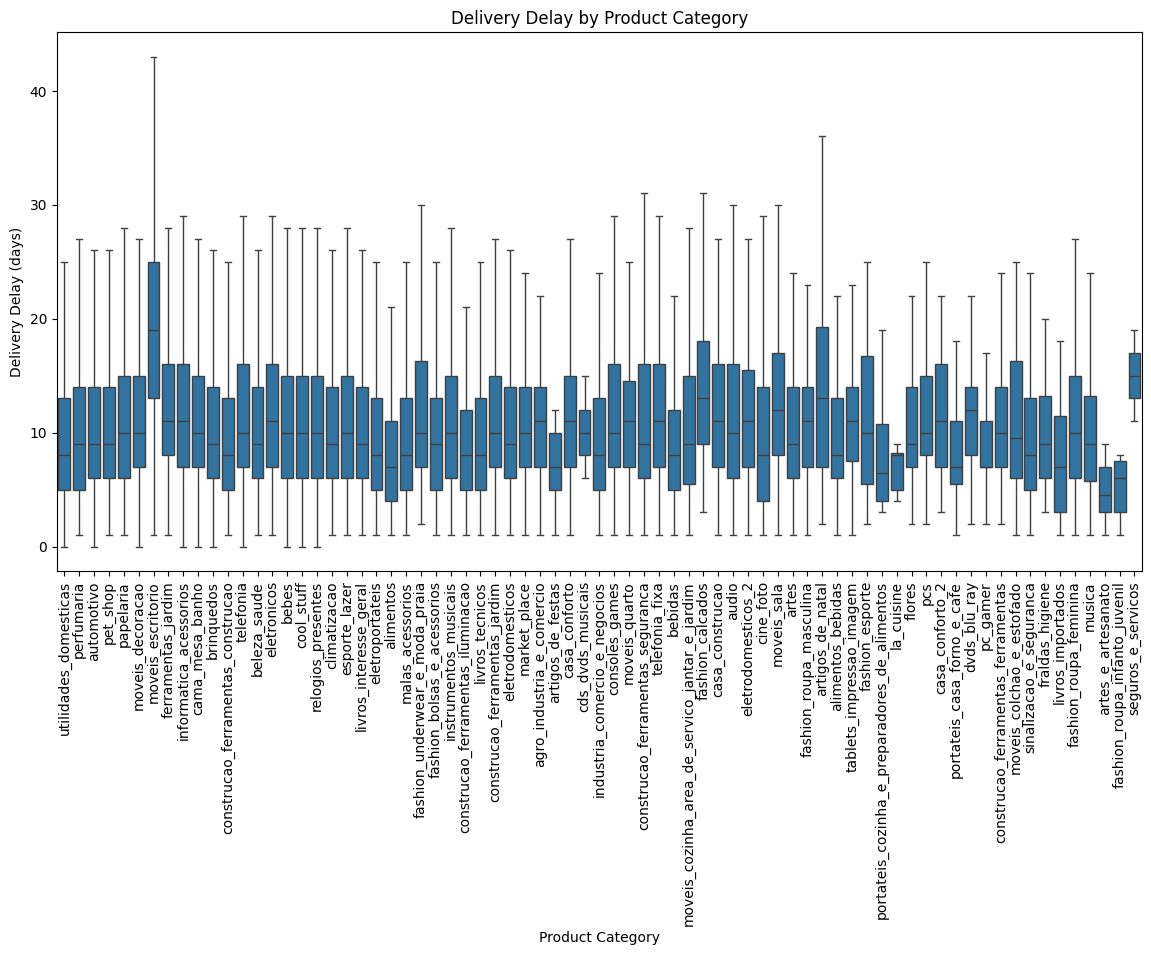

In [9]:
# Menampilkan visualisasi data dari pertanyaan pertama terkait dengan keterlambatan pengiriman
if 'product_category_name' in orders_filtered.columns:
    plt.figure(figsize=(14, 7))
    sns.boxplot(data=orders_filtered, x='product_category_name', y='delivery_delay', showfliers=False)
    plt.xticks(rotation=90)
    plt.title("Delivery Delay by Product Category")
    plt.xlabel("Product Category")
    plt.ylabel("Delivery Delay (days)")
    plt.show()


**Insight:**
- Beberapa kategori produk memiliki waktu pengiriman yang lebih lama, kemungkinan karena ukuran, lokasi, atau proses logistik yang lebih kompleks.
- Jika ada kategori dengan median keterlambatan tinggi, bisa jadi produk tersebut sering mengalami kendala distribusi, seperti stok yang tidak tersedia di gudang terdekat.


### Pertanyaan 2: Bagaimana hubungan antara metode pembayaran yang digunakan pelanggan dengan nilai total transaksi dan tingkat pengembalian produk?

<ipython-input-10-66aa2301f174>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=payment_group, x='payment_type', y='payment_value', palette='coolwarm')


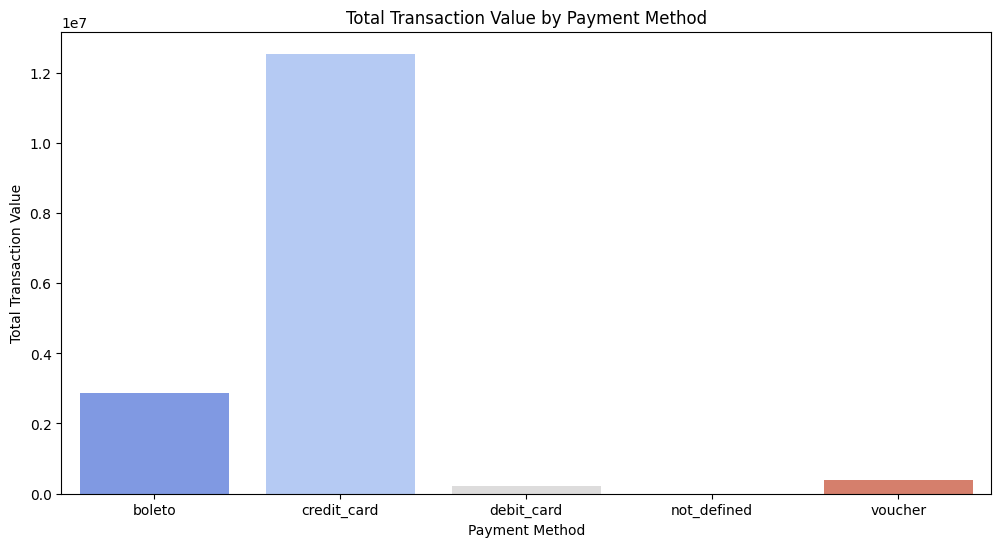

In [10]:
# Membuat visualisasi data terkait pertanyaan kedua tentang metode pembayaran
payment_group = payments.groupby('payment_type').agg({
    'payment_value': 'sum',
    'order_id': 'count'
}).reset_index()
returns['is_returned'] = returns['review_score'].apply(lambda x: 1 if x <= 2 else 0)
return_rates = returns.groupby('order_id')['is_returned'].mean().reset_index()
orders_filtered = orders_filtered.merge(return_rates, on='order_id', how='left')

plt.figure(figsize=(12, 6))
sns.barplot(data=payment_group, x='payment_type', y='payment_value', palette='coolwarm')
plt.title("Total Transaction Value by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Total Transaction Value")
plt.show()

**Insight:**
- Metode pembayaran tertentu mendominasi total transaksi, menunjukkan preferensi pelanggan.
- Beberapa metode pembayaran memiliki transaksi rendah, mungkin karena kurangnya kenyamanan atau promosi.
- Optimalisasi strategi pembayaran dapat difokuskan pada metode yang paling sering digunakan pelanggan.

## Analisis Lanjutan (Return rate & RFM Analysis)

Kolom dalam returns: Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'is_returned'],
      dtype='object')


<ipython-input-11-b98545e7054e>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=orders_filtered, x='Return Category', palette='coolwarm')


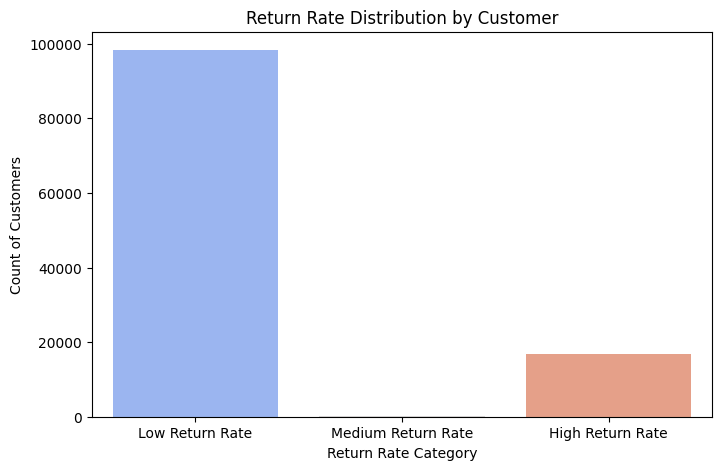

In [11]:
# Pastikan kolom yang tersedia di returns
print("Kolom dalam returns:", returns.columns)

if 'review_score' in returns.columns:
    returns['is_returned'] = returns['review_score'].apply(lambda x: 1 if x <= 2 else 0)
    returns = returns.merge(orders_filtered[['order_id', 'customer_id']], on='order_id', how='left')
    if 'customer_id' not in returns.columns:
        print("⚠️ Kolom 'customer_id' masih tidak ditemukan setelah merge.")
    else:

        return_rates = returns.groupby('customer_id', as_index=False)['is_returned'].mean()
        orders_filtered = orders_filtered.merge(return_rates, on='customer_id', how='left', suffixes=('', '_new'))
        orders_filtered['is_returned'] = orders_filtered['is_returned'].fillna(0)
        orders_filtered['Return Category'] = pd.cut(
            orders_filtered['is_returned'],
            bins=[-0.1, 0.2, 0.5, 1.0],
            labels=['Low Return Rate', 'Medium Return Rate', 'High Return Rate']
        )

        # Visualisasi return rate per kategori
        plt.figure(figsize=(8, 5))
        sns.countplot(data=orders_filtered, x='Return Category', palette='coolwarm')
        plt.title("Return Rate Distribution by Customer")
        plt.xlabel("Return Rate Category")
        plt.ylabel("Count of Customers")
        plt.show()

**Insight**
- Sebagian besar pesanan tidak dikembalikan, menunjukkan tingkat kepuasan pelanggan yang cukup baik.
- Persentase pengembalian yang kecil dapat disebabkan oleh kebijakan retur yang ketat atau kualitas produk yang sesuai ekspektasi.
- Analisis lebih lanjut diperlukan untuk memahami faktor yang mempengaruhi pengembalian, seperti kategori produk atau metode pembayaran.








            Recency     Frequency       Monetary  Avg_Delivery_Delay  \
count  96205.000000  96205.000000   96205.000000        96205.000000   
mean     237.879601      1.199304     206.002021           12.073957   
std      151.184709      0.749402     625.310282            9.535653   
min        0.000000      1.000000       9.590000            0.000000   
25%      115.000000      1.000000      62.820000            6.000000   
50%      219.000000      1.000000     110.000000           10.000000   
75%      348.000000      1.000000     196.010000           15.000000   
max      613.000000     63.000000  109312.640000          209.000000   

        Return_Rate  
count  96205.000000  
mean       0.127052  
std        0.332697  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  


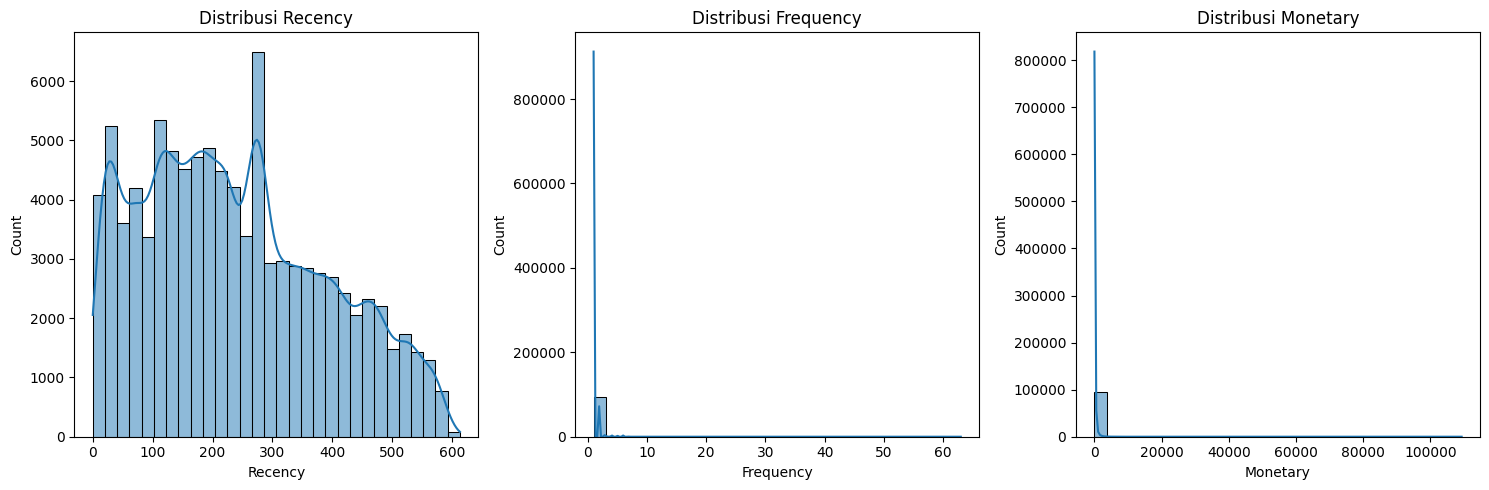

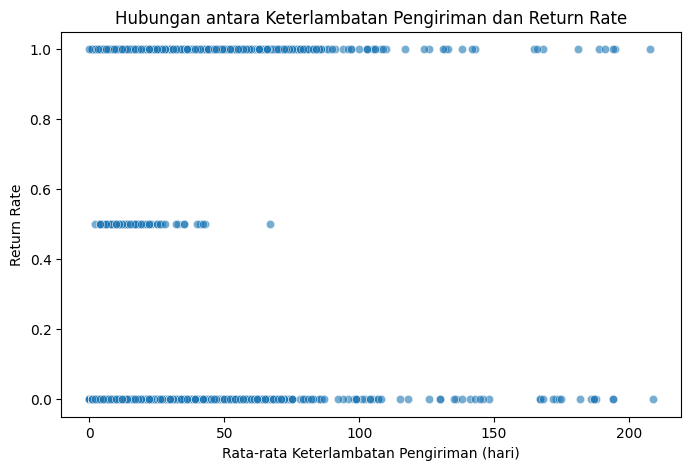

<ipython-input-12-c0e3aaa2b885>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=payment_group, x='payment_type', y='payment_value', palette='coolwarm')


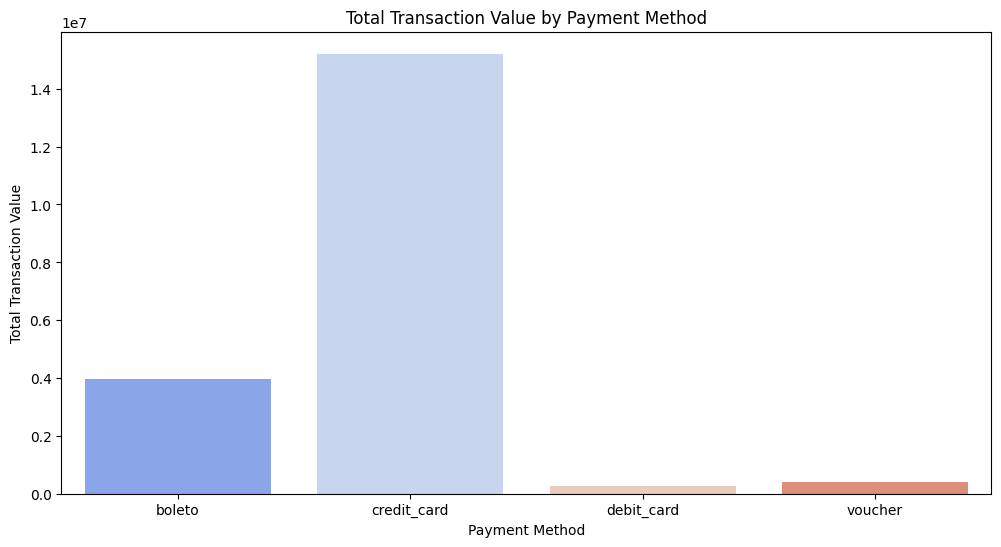

<ipython-input-12-c0e3aaa2b885>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=return_payment, x='payment_type', y='is_returned', palette='magma')


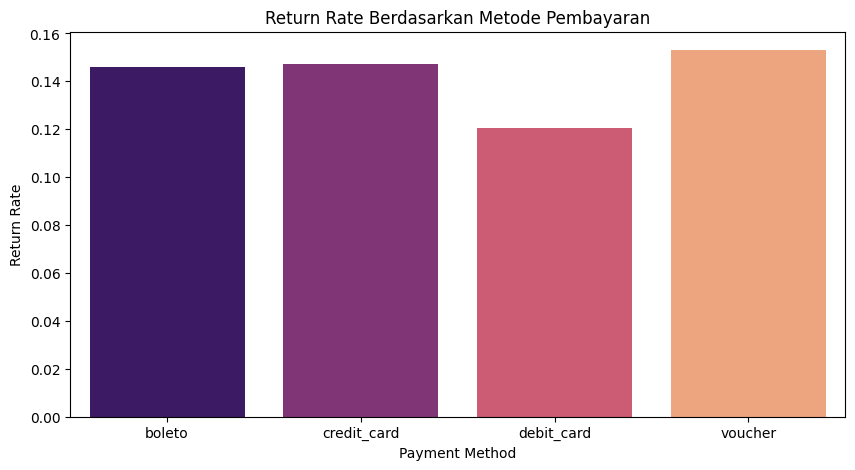

In [12]:
# Pastikan order_purchase_timestamp dalam format datetime
orders_filtered['order_purchase_timestamp'] = pd.to_datetime(orders_filtered['order_purchase_timestamp'])

# Tentukan tanggal referensi (misalnya, tanggal terbaru dalam dataset)
latest_date = orders_filtered['order_purchase_timestamp'].max()

# Buat Data RFM
rfm = orders_filtered.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (latest_date - x.max()).days if not x.empty else None,  # Recency
    'order_id': 'count',
    'payment_value': 'sum',
    'delivery_delay': 'mean',
    'is_returned': 'mean'
}).reset_index()

# Perbaiki nama kolom agar lebih jelas
rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary', 'Avg_Delivery_Delay', 'Return_Rate']

# Isi NaN dengan 0 untuk pelanggan yang belum pernah return atau belum ada delay
rfm.fillna({'Avg_Delivery_Delay': 0, 'Return_Rate': 0}, inplace=True)

# Analisis Deskriptif
print(rfm.describe())

# Visualisasi Distribusi RFM
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(rfm['Recency'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribusi Recency')

sns.histplot(rfm['Frequency'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribusi Frequency')

sns.histplot(rfm['Monetary'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Distribusi Monetary')

plt.tight_layout()
plt.show()

# Analisis Keterlambatan Pengiriman dan Return Rate
plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm, x='Avg_Delivery_Delay', y='Return_Rate', alpha=0.6)
plt.title("Hubungan antara Keterlambatan Pengiriman dan Return Rate")
plt.xlabel("Rata-rata Keterlambatan Pengiriman (hari)")
plt.ylabel("Return Rate")
plt.show()

# Analisis Metode Pembayaran
payment_group = orders_filtered.groupby('payment_type').agg({
    'payment_value': 'sum',
    'order_id': 'count'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=payment_group, x='payment_type', y='payment_value', palette='coolwarm')
plt.title("Total Transaction Value by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Total Transaction Value")
plt.show()

# Hubungan antara metode pembayaran dan return rate
orders_filtered['is_returned'] = orders_filtered['is_returned'].fillna(0)
return_payment = orders_filtered.groupby('payment_type')['is_returned'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=return_payment, x='payment_type', y='is_returned', palette='magma')
plt.title("Return Rate Berdasarkan Metode Pembayaran")
plt.xlabel("Payment Method")
plt.ylabel("Return Rate")
plt.show()


**Insight**
- Sebagian besar pelanggan hanya membeli sekali → Perlu strategi retensi pelanggan, seperti program loyalitas atau diskon untuk pembelian berikutnya.
- Semakin lama pengiriman, semakin tinggi return rate → Optimasi logistik dan transparansi estimasi pengiriman dapat mengurangi return.
- Metode pembayaran tertentu memiliki return rate lebih tinggi → Evaluasi kebijakan refund dan edukasi pelanggan tentang metode pembayaran.
- Distribusi nilai transaksi menunjukkan gap besar antara pelanggan dengan nilai belanja tinggi dan rendah → Bisa dilakukan segmentasi pelanggan untuk strategi pemasaran yang lebih tepat sasaran.
- Banyak pelanggan tidak belanja lagi setelah pembelian pertama (Recency tinggi) → Kampanye re-engagement seperti email reminder atau promo eksklusif bisa meningkatkan repeat purchase.

## Conclusion

1. CONCLUSION PERTANYAAN PERTAMA
- Analisis dilakukan untuk melihat bagaimana keterlambatan pengiriman bervariasi berdasarkan jenis produk dan lokasi pelanggan dalam dua tahun terakhir.
- Faktor yang mungkin mempengaruhi keterlambatan termasuk ukuran produk, stok gudang, dan jarak pengiriman.
- Dapat digunakan heatmap atau boxplot untuk mengidentifikasi kategori dengan median keterlambatan tinggi dan daerah dengan waktu pengiriman lebih lama.
2. CONCLUSION PERTANYAAN KEDUA
- Beberapa metode pembayaran mungkin lebih sering digunakan oleh pelanggan dengan nilai transaksi tinggi.
- Perlu analisis apakah metode tertentu lebih sering dikaitkan dengan return rate yang lebih tinggi, misalnya, COD atau kartu kredit.
- Visualisasi seperti scatter plot atau bar chart dapat digunakan untuk menunjukkan pola hubungan antara metode pembayaran, nilai transaksi, dan tingkat pengembalian.
3. ANALISIS LANJUTAN
- Return Rate
  - Identifikasi faktor utama yang mempengaruhi return, seperti kategori produk, durasi pengiriman, atau metode pembayaran.
  - Model prediktif dapat digunakan untuk memperkirakan kemungkinan return berdasarkan pola transaksi sebelumnya.
- RFM Analysis
  - Segmentasi pelanggan berdasarkan Recency (seberapa baru mereka membeli), Frequency (seberapa sering mereka berbelanja), dan Monetary (total nilai transaksi).
  - Pelanggan dengan Recency tinggi (jarang membeli) perlu strategi re-engagement seperti promo eksklusif atau email reminder.
  - Pelanggan dengan Frequency rendah dapat ditargetkan dengan program loyalitas untuk meningkatkan repeat purchase.

In [17]:
output_folder = "output_analysis"
os.makedirs(output_folder, exist_ok=True)

final_results = orders_filtered.merge(rfm, on='customer_id', how='left')
final_results = final_results.merge(payment_group, on='payment_type', how='left')
final_results = final_results.merge(return_payment, on='payment_type', how='left')

# File csv gabungan terakhir
final_results.to_csv(os.path.join(output_folder, "final_analysis.csv"), index=False)

from google.colab import files
files.download("output_analysis/final_analysis.csv")


Hasil analisis telah disimpan dalam satu file CSV di folder 'output_analysis'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>